<a href="https://colab.research.google.com/github/Sakutwf/ProyectoFinalMachineLearning/blob/main/Proyecto_Final_Machine_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

La contaminación atmosférica es una de las preocupaciones ambientales más importantes en muchos países del mundo, y se ve fuertemente afectada por las condiciones meteorológicas. En este proyecto se generarán pronósticos para la calidad del aire disponibles para la ciudad de Curicó.

In [38]:
#Importación de librerías

import numpy as np
import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
from fbprophet import Prophet
import holidays
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler



3. Extracción de la base de datos de calidad del aire de la estación meteorológica ubicada en Curicó.

In [39]:
url = r"https://sinca.mma.gob.cl/cgi-bin/APUB-MMA/apub.tsindico2.cgi?outtype=xcl&macro=./RVII/709/Cal/PM25//PM25.horario.horario.ic&from=120707&to=211130&path=/usr/airviro/data/CONAMA/&lang=esp&rsrc=&macropath="
csv = pd.read_csv(url, error_bad_lines=False, sep=";", na_values='?', na_filter=True, engine='python')

4. Se realizará un preprocesamiento se datos con el fin de permitir un trabajo más claro y fácil. Se solicita llegar al formato datetime de Python. Se detallan las acciones paso a paso:

In [40]:
#De ahora en adelante los datos se llamarán desde la variable df
df = csv.copy()

La primera columna que se tratará es la de Fecha

In [41]:
#transformando a datos de tipo String
df['FECHA (YYMMDD)'] = df['FECHA (YYMMDD)'].astype(str)

#La fecha se separará en día, mes y año, para ello, en primer lugar, se extraerá la columna de interés
auxDate = df['FECHA (YYMMDD)']

#Se extraen los datos de día, mes y año para dar nuevo formato
year = auxDate.str[:2]
month = auxDate.str[2:4]
day = auxDate.str[4:]

#Se da nuevo formato
df['FECHA (YYMMDD)'] = year+"/"+month+"/"+day

La siguiente columna a modificar es la de Hora

In [42]:
#Así como en la columna anrerior, se transforma a tipo String y se extrae la columna
df['HORA (HHMM)'] = df['HORA (HHMM)'].astype(str)
auxHour = df['HORA (HHMM)']

#Para transformar el formato de la columna de horas será necesario realizar verificaciones en cada celda para la tranformación
#Para ello se creará una lista auxiliar que contendra los nuevos valores para luego asignarlos a la columna definitiva
auxList = []

#Verificación de formato
for index, row in auxHour.iteritems():
    lenght = len(row)
    if(lenght == 1):
        newRow = "000"+row
    if(lenght == 3):
        newRow = "0"+row
    if(lenght == 4):
        newRow = row
    hour = newRow[:2]
    minute = newRow[2:]
    auxList.append(hour+":"+minute+":00.000")

#Se le asigna a la columna de hora los valores de la lista con formato actualizado
df['HORA (HHMM)'] = auxList

5. Para una mayor comodidad en la lectura de datos, las columnas que acaban de modificarse se unirán en una sola llamada Time, de esta manera se podrá utilizar el formato de python para este tipo de archivos, así.. fecha y hora quedará como una sola y nueva columna y las antiguas serán eliminadas.

In [43]:
df1 = df.copy()

#Se unen en una nueva columna "Fecha" y "Hora"
df1['Fecha'] = df1['FECHA (YYMMDD)'] + " " + df1['HORA (HHMM)']

#Se lleva la nueva columna al inicio del dataframe
cols = df1.columns.to_list()
cols = cols[-1:] + cols[:-1]
df1 = df1[cols]

#Se eliminan columnas "Fecha" y "Hora"
df1.drop(['FECHA (YYMMDD)','HORA (HHMM)'], axis=1, inplace=True)

#Se lleva la nueva columna al formato datetime
df1['Fecha'] = pd.to_datetime(df1['Fecha'], yearfirst=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



6. A continuación se aplicarán estrategias de imputación de dstos según se requiera, para ello en una primera instancia se revisará cuantos datos faltan y en que lugar a fin de utilizar el mejor criterio de imputación de acuerdo al dataframe.

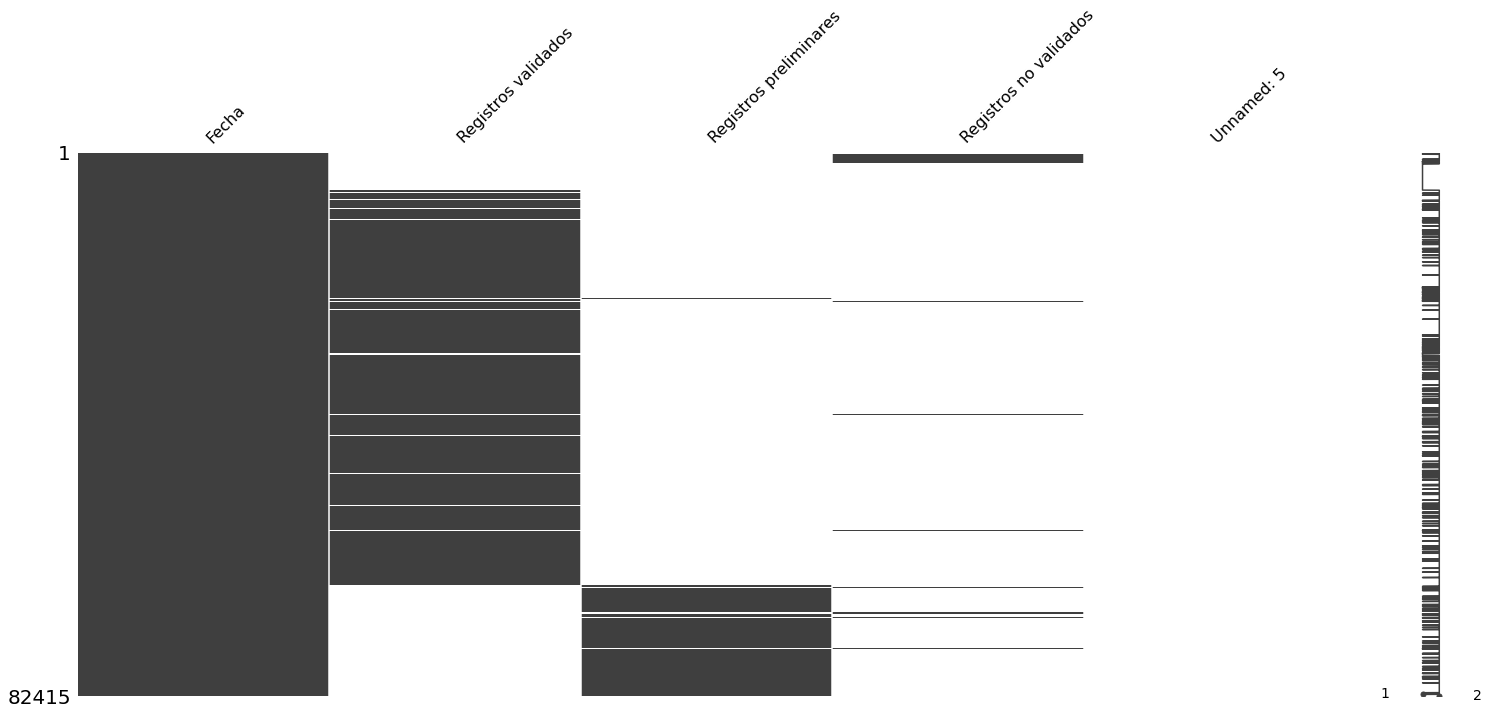

In [44]:
#Con la herramienta Missingno se conocerán todos aquellos datos tipo NaN
msno.matrix(df1)
plt.show()

Como se puede observar, existen 2 columnas con ausencia casi total de datos, por lo que se rescatarán las columnas restantes para trabajar, para ello se ha decidido unir Registros validados y Registros preliminares en una sola columna de Registros:

In [46]:
df2 = df1.copy()
toolData = pd.DataFrame(df2[['Fecha']])
toolData['Registros validados'] = df2['Registros validados']
toolData['Registros preliminares'] = df2['Registros preliminares']
toolData['Registro'] = df2['Registros validados'].astype(str) + df2['Registros preliminares'].astype(str)

#Como ya se han juntado las columnas de registros validados y preliminares, se elimina el resto

toolData.drop(['Registros validados','Registros preliminares'], axis=1, inplace=True)

#Como se observó en el punto anterior, existen filas que no poseen datos, por lo que la ausencia de ellos
#Se representará con un NaN, junto con ello, los datos se transformarán a tipo float
auxRegistro = toolData['Registro']
auxRegistro1 = []
for index, item in auxRegistro.iteritems():
    auxRegistro1.append(item.replace("nan",""))    
toolData['Registro'] = auxRegistro1

toolData = toolData.replace(r'^\s*$', np.NaN, regex=True)
toolData = toolData.replace(r',', '.', regex=True)
toolData['Registro'] = toolData['Registro'].astype(float)

In [47]:
#revisar datos atipicos
df2 = df2.replace(r',', '.', regex=True)
items = df2['Registros preliminares'].astype(float)
for index, item in items.iteritems():
    if (item >400 ):
        print(item)

447.0
408.0
424.0
500.0
405.0


En una primera instancia se decidió utilizar la media como medio de inputación para los datos faltantes, debido a que el porcentaje de datos que no había era de casi un 10%, sin embargo esto afectaba directamente al modelo final, se comprobó en el bloque de código anterior valores sobre 400 de la columna de preliminares, por lo que finalmente se optó por eliminar simplemente las filas de los datos faltantes, de esta manera se evitará crear variables de registro sesgadas por datos atípicos.

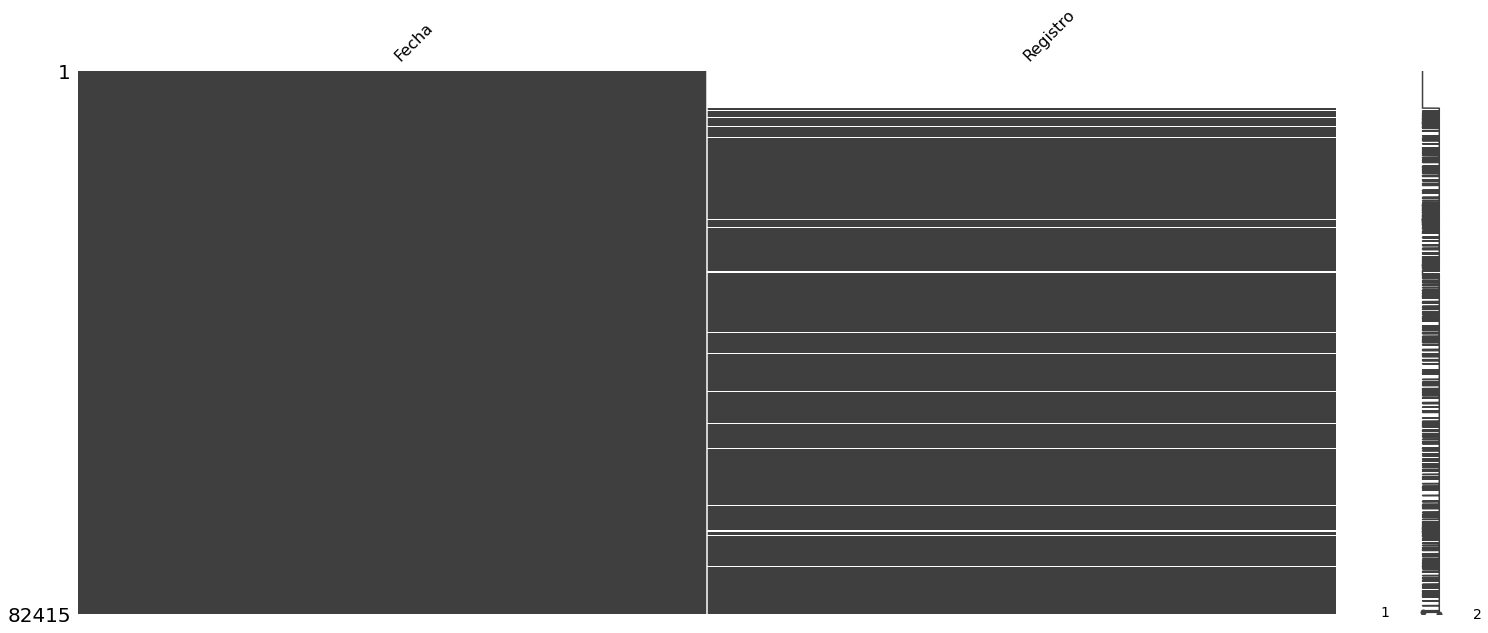

Fecha          0
Registro    8188
dtype: int64


In [48]:
msno.matrix(toolData)
plt.show()

print(toolData.isnull().sum())

Eliminando filas con datos de tipo na

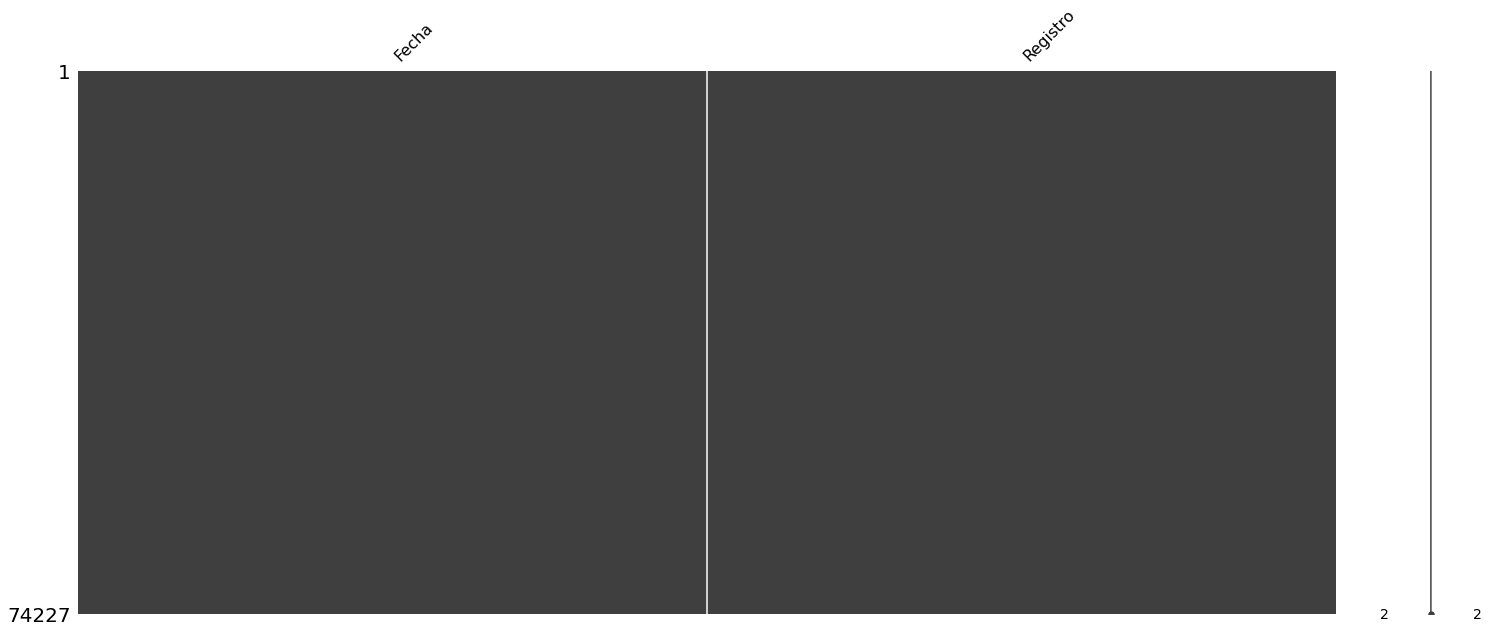

Fecha       0
Registro    0
dtype: int64


In [49]:
toolData = toolData.dropna()
msno.matrix(toolData)
plt.show()
print(toolData.isnull().sum())

7. se grafica finalmente la serie de tiempo con los registros de calidad de aire en el tiempo


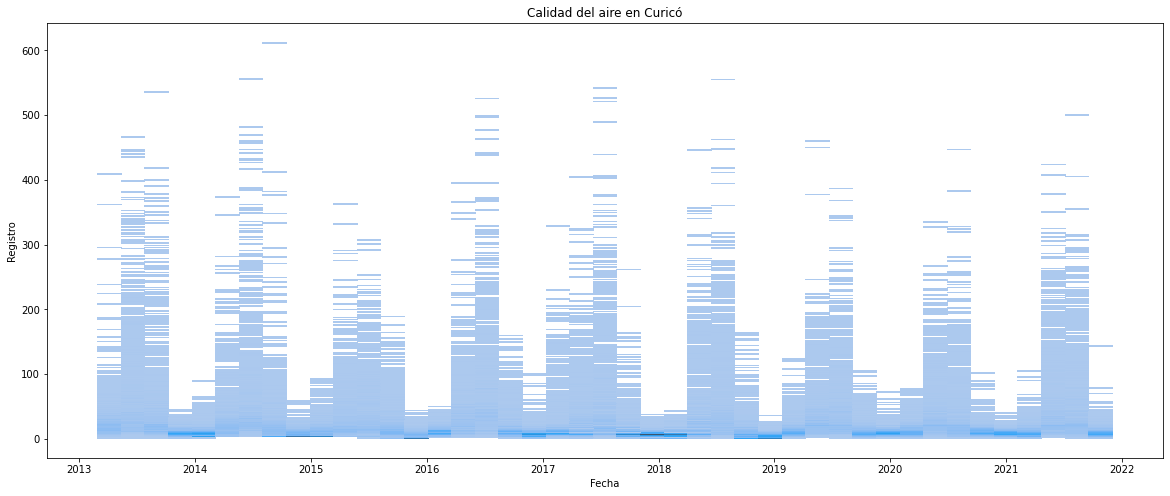

In [54]:
graph = sns.histplot(toolData, x="Fecha", y="Registro")
graph.set_title("Calidad del aire en Curicó")
plt.gcf().set_size_inches(20, 8)

8. Para la separación de datos para entrenamiento y validación, se crean 3 dataframe distintos, uno que contiene el grupo de datos que se utilizará para realizar las pruebas, otro que servirá de testeo y uno adicional que contiene los registros de fecha anteriores a estos dos.

In [63]:
testDF = toolData.copy()

originalData = testDF.loc[testDF.Fecha<'2016-01-01 00:00:00']
trainData = testDF.loc[(testDF.Fecha>='2016-01-01 00:00:00') & (testDF.Fecha <'2020-01-01 00:00:00')]
testData = testDF[testDF.Fecha >= '2020-01-01 00:00:00']

Luego de probar con distintas combinaciones a fin de disminuir la divergencia y el MAPE final, se obtuvo que las fechas de entrenamiento serian desde el 1 de enero del 20 al 1 de enero del 1, la data original contendría todos los registros antes de esta fecha y la data de validación todos los registros de después.

Para una mejor visualización  de como quedaron las divisiones se vuelven a graficar :

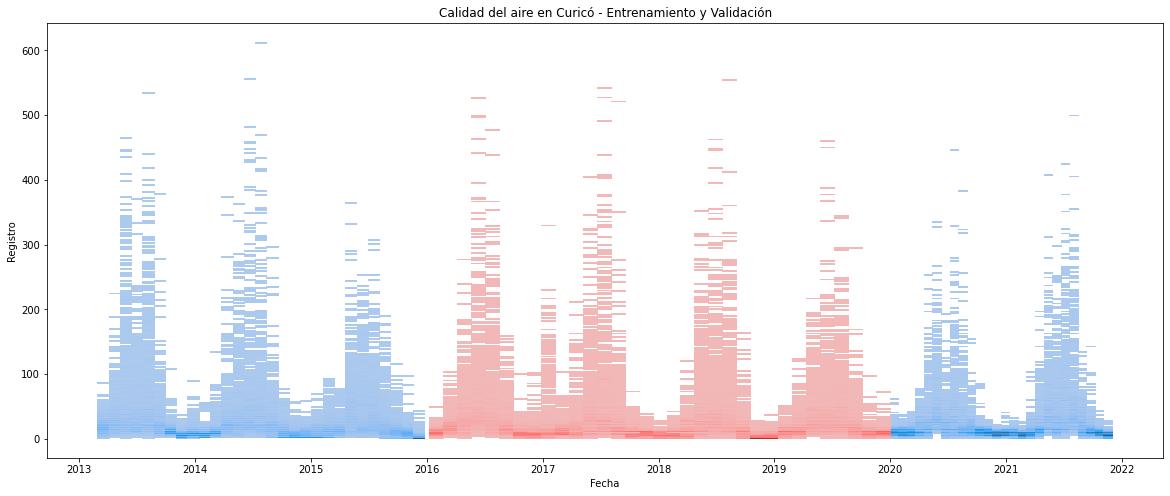

In [64]:
graph2 = sns.histplot(originalData, x="Fecha", y="Registro")
graph2 = sns.histplot(testData, x="Fecha", y="Registro")
graph2 = sns.histplot(trainData, x="Fecha", y="Registro", color='red')
graph2.set_title("Calidad del aire en Curicó - Entrenamiento y Validación")
plt.gcf().set_size_inches(20, 8)
plt.show()

9. Se realiza el entrenamiento del modelo prophet:

In [90]:
trainData['cap'] = 0.55
testData['cap'] = 0.55

trainData.rename(columns = {"Fecha":"ds","Registro":"y"}, inplace=True)
testData.rename(columns = {"Fecha":"ds","Registro":"y"}, inplace=True)

years = range(2012,2021)

chileanHolidays = holidays.CL(years=years)
dataHolidays = pd.DataFrame.from_dict(chileanHolidays, orient="index").reset_index()
dataHolidays.columns = ["ds","holiday"]

model = Prophet(
    growth='logistic',
    changepoints=None,
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=True,
    holidays=dataHolidays,
    mcmc_samples=34,
    interval_width=0.2
)

model.fit(trainData)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a

In [91]:
forecast = model.predict(testData)
forecast_ci = forecast[["ds","yhat","yhat_lower","yhat_upper"]].set_index("ds")

yhat_test = forecast.yhat.values
y_test = testData[['y']]

forecast_ci.head()

,yhat,yhat_lower,yhat_upper
ds,,,
2020-01-01 00:00:00,19.037279,9.779767,30.039973
2020-01-01 01:00:00,14.530669,4.564064,26.896059
2020-01-01 02:00:00,9.799737,-0.952378,20.016510
2020-01-01 03:00:00,5.158775,-6.302289,18.137145
2020-01-01 04:00:00,1.457342,-7.917271,11.552866


Se grafican los resultados:

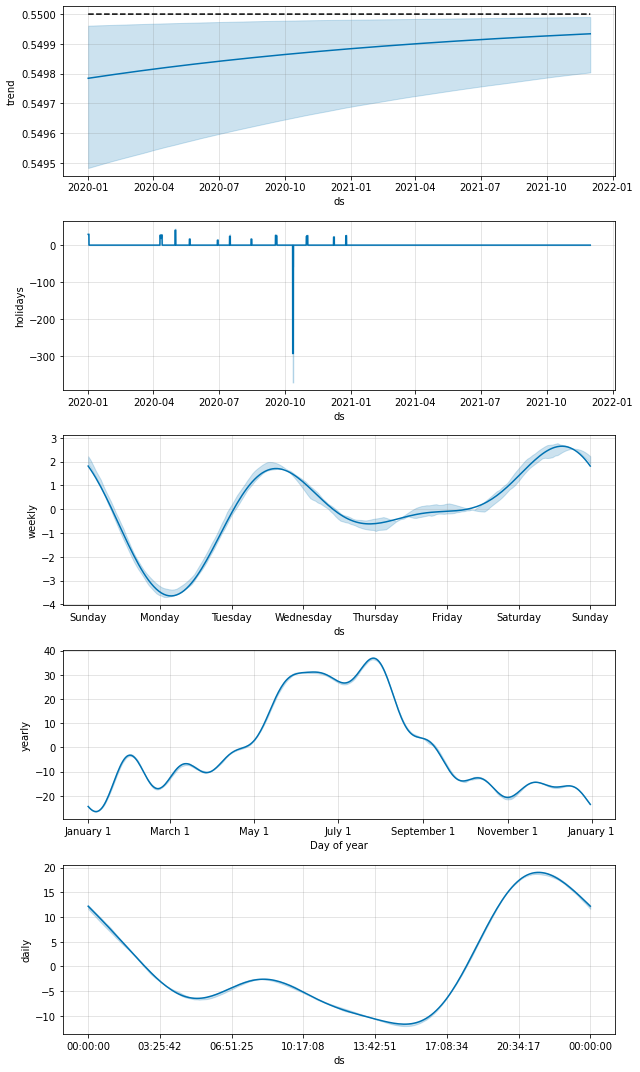

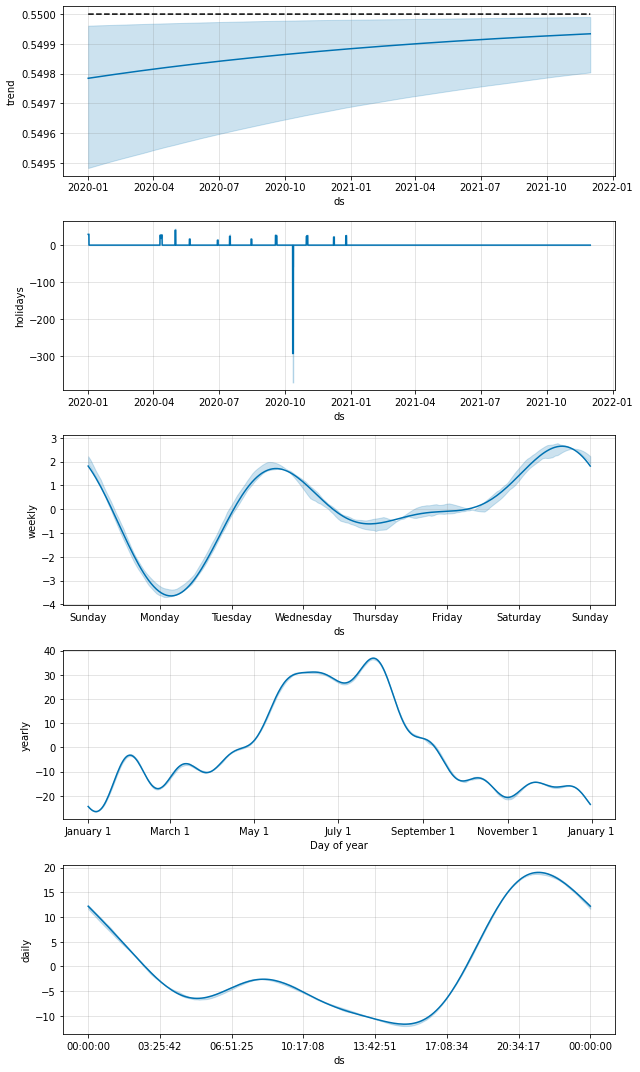

In [92]:
model.plot_components(forecast)

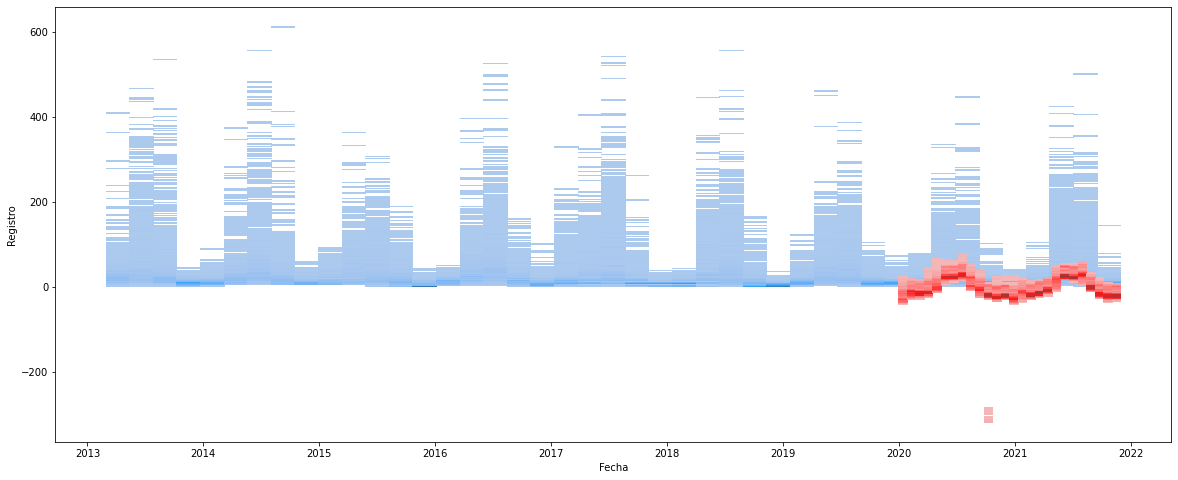

In [93]:
sns.histplot(toolData, x="Fecha", y="Registro")
sns.histplot(x=testData['ds'].tolist(), y=yhat_test, color='red')
plt.gcf().set_size_inches(20, 8)
plt.show()

A continuación se muestran los resultados obtenidos del modelo prophet, los que luego de haber probado distintos parámetros, quedaron con los siguientes resultados:

In [94]:
mae = mean_absolute_error(y_test, yhat_test)
mape = mean_absolute_percentage_error(y_test, yhat_test)
mse = mean_squared_error(y_test, yhat_test)
print("MAE (test): {:0.6f}".format(mae))
print("MAPE (test): {:0.6f}".format(mape))
print("MSE (test): {:0.6f}".format(mse))

MAE (test): 26.837697
MAPE (test): 1.930364
MSE (test): 1555.012904
